In [ ]:
# !pip install --upgrade scipy numpy faststylometry scikit-learn
!pip install textstat

In [9]:
# import modules
# import spacy
# from spacy import displacy
import matplotlib.pyplot as plt
import pandas as pd
import os, re, random
from glob import glob
from faststylometry.corpus import Corpus
from faststylometry import tokenise_remove_pronouns_en
from faststylometry import calculate_burrows_delta
from faststylometry import predict_proba, calibrate, get_calibration_curve
import numpy as np



### Burrows Delta Results Issue Diagnosis -- Not Part of Analysis

In [20]:
# THIS IS USED TO DEBUG THE ISSUE WITH BURROWS DELTA RESULTS

# BEFORE CORRECTION

# len(train_corpus.books) # 212794 - List of Book ids
# len(test_corpus.books) # 4264 - ******

# len(test_corpus.all_unique_authors) # 1000
# len(train_corpus.all_unique_authors) # 2

# len(train_corpus.top_tokens) # 50 - A list of 50 most common words
# len(test_corpus.top_tokens) # 50 -  *******
# len(train_corpus.top_tokens_set) #50  50 - A set consisting of 50 most common words
# len(test_corpus.top_tokens_set) #50   ******

# len(train_corpus.tokens) # 212794 - list of lists. Inner list is tokenised sentences
# len(test_corpus.tokens) # 4264 ******



# train_corpus.token_counts # A 2D Numpy array. Row represents each sentence. Column represents each of the 50 top tokens 
# train_corpus.total_token_counts # A list whose elements are number of tokens in each sentence
# test_corpus.token_counts# A 2D Numpy array. Row represents each sentence. Column represents each of the 50 top tokens 
# test_corpus.total_token_counts # A list whose elements are number of tokens in each sentence

# len(train_corpus.author_book_combinations) # 212794  # List of author - book Eg: ['human - 4082', 'human - 4082']
# len(test_corpus.author_book_combinations) # 4264  ******


# train_corpus.author_to_author_id # Return : {'human': 0, 'machine': 1}
# test_corpus.author_to_author_id
# train_corpus.author_ids # Similar to train_corpus.authors, author name replaced with ID ,ie, 1 or 0

# train_corpus.token_counts_by_author.shape # Return : (50,2) # A 2D array. Rows represent 50 top words, Columns represent 2 unique authors
# test_corpus.token_counts_by_author.shape # Return : (50,1000)

# train_corpus.total_token_counts_by_author # Return value array([1276373., 2496860.]) #  1D Array of 2 elements . Total tokens by author 0 and author 1 respectively
# test_corpus.total_token_counts_by_author.shape # 1D Array of length 1000

# train_corpus.token_proportions.shape # A 50 x 2 Array. Obtained by dividing token_counts_by_author by total_token_counts_by_author
# test_corpus.token_proportions.shape # 50 x 1000 Array


# train_corpus.author_z_scores.shape # A 50 x 2 array of normalised token frequencies. Row represents words and Column the author (human/machine)
# test_corpus.author_z_scores.shape # A 50 X 1000 array

# len(test_corpus.all_unique_authors)
# test_corpus.difference_matrix.shape # (4264, 50, 2)
#test_corpus.token_counts_by_author.shape




In [3]:
df_train, df_test = burrows_read_input_json("dev-labels")

NameError: name 'burrows_read_input_json' is not defined

# Burrows Delta

In [14]:
from faststylometry.corpus import Corpus
from faststylometry import tokenise_remove_pronouns_en
from faststylometry import calculate_burrows_delta
from faststylometry import predict_proba, calibrate, get_calibration_curve
from sklearn.naive_bayes import MultinomialNB, ComplementNB
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import textstat # https://pypi.org/project/textstat/
import pandas as pd
import json
import math

# Read the input train and test json files into train and test dataframes
def burrows_read_input_json(phase):

    df_train = pd.read_json('../alta2024_public_data/train.json')
    df_train = df_train.explode('sent_and_label')
    df_train = df_train.explode('sent_and_label')
    df_train = pd.DataFrame({'id':df_train['id'].iloc[1::2],
                        'domain':df_train['domain'].iloc[1::2],
                        'sent':df_train['sent_and_label'].iloc[::2].values, 
                        'label':df_train['sent_and_label'].iloc[1::2].values})                     
    df_train['index'] = df_train.groupby('id').cumcount() + 1
    df_train['id'] = df_train['id'].astype(str)  +  "-"  +  df_train['index'].astype(str) 
    df_train = df_train.drop('index', axis = 1)

    if phase == "dev-labels" :
        
        df_test = pd.read_json('../alta2024_public_data/phase1_test_with_labels.json')
        df_test = df_test.explode('sent_and_label')
        df_test = df_test.explode('sent_and_label')
        df_test = pd.DataFrame({'id':df_test['id'].iloc[1::2],
                            'domain':df_test['domain'].iloc[1::2],
                            'sent':df_test['sent_and_label'].iloc[::2].values, 
                            'label':df_test['sent_and_label'].iloc[1::2].values})
        #Generating unique IDs
        df_test['index'] = df_test.groupby('id').cumcount() + 1
        df_test['id'] = df_test['id'].astype(str)  +  "-"  +  df_test['index'].astype(str) 
        df_test = df_test.drop('index', axis = 1)


    elif phase == "dev-no-labels":

        df_test = pd.read_json('../alta2024_public_data/phase1_test_without_labels.json')
        df_test = df_test.explode('sent')
        df_test = pd.DataFrame({'id':df_test['id'],
                            'domain':df_test['domain'],
                            'sent':df_test['sent'].values})
        df_test['index'] = df_test.groupby('id').cumcount() + 1
        df_test['id'] = df_test['id'].astype(str)  +  "-"  +  df_test['index'].astype(str) 
        df_test = df_test.drop('index', axis = 1)
        df_test['label'] = ["1" for i in df_test['id']]

    elif phase == "test":

        df_test = pd.read_json('../alta2024_public_data/phase2_test_without_labels.json')
        df_test = df_test.explode('sent')
        df_test = pd.DataFrame({'id':df_test['id'],
                            'domain':df_test['domain'],
                            'sent':df_test['sent'].values})
        df_test['index'] = df_test.groupby('id').cumcount() + 1
        df_test['id'] = df_test['id'].astype(str)  +  "-"  +  df_test['index'].astype(str) 
        df_test = df_test.drop('index', axis = 1)
        df_test['label'] = ["1" for i in df_test['id']]

    else:
        print("Specify phase")
        return None
 
    return df_train, df_test

# Returns train and test corpus when train and test dataframes are passed in
def burrows_corpus_make(df_train, df_test):
    train_corpus = Corpus()
    for label,id,sent in zip(df_train['label'],df_train['id'],df_train['sent']):
        train_corpus.add_book(label, str(id), sent)

    test_corpus = Corpus()
    for label,id,sent in zip(df_test['label'],df_test['id'],df_test['sent']):
        test_corpus.add_book(label, str(id), sent)

    train_corpus.tokenise(tokenise_remove_pronouns_en)
    test_corpus.tokenise(tokenise_remove_pronouns_en)

    return train_corpus, test_corpus

# Make predictions on test set based on burrows delta
def burrows_predictions_make(train_corpus, test_corpus , df_test, vocab_size=10):

    burrows_pred_df = calculate_burrows_delta(train_corpus, test_corpus ,vocab_size)

    burrows_pred_series = burrows_pred_df.idxmin().copy()
    b = [ind.split(" - ")[1] for ind in burrows_pred_series.index]
    burrows_pred = list(pd.Series(data = list(burrows_pred_series), index = b).reindex(df_test['id']))
    burrows_pred = ["machine" if (pred != "machine" and pred != "human") else pred for pred in burrows_pred]
    return burrows_pred

# Returns Kappa scores based on predicitions and phase(dev or test)
def kappa_score_burrows(burrows_pred , df_test, phase):
    if phase != 'dev-labels':
        print("No test labels available. Hence no kappa scores")
    else:
        print("Kappa score is ", cohen_kappa_score(burrows_pred,df_test['label']))

# Wrapper function to return burrows-delta based predictions that takes the phase as the input parameter
# phase can take values such as "dev-labels", "dev-no-labels" and "test"
def burrows_all_steps(phase):

    df_train, df_test = burrows_read_input_json(phase)

    train_corpus, test_corpus = burrows_corpus_make(df_train, df_test)
    burrows_preds = burrows_predictions_make(train_corpus, test_corpus, df_test, 10)
    kappa_score_burrows(burrows_preds , df_test, phase)
    make_json(burrows_preds, df_test)
    return burrows_preds

# Function that returns confidence scores for the predicted label to be "machine". 
# A higher confidence score means higher chance of the predicted label being "machine"
def burrows_pred_scores(phase="dev-labels"):
    df_train, df_test = burrows_read_input_json(phase)
    train_corpus, test_corpus = burrows_corpus_make(df_train, df_test)
    result = calculate_burrows_delta(train_corpus, test_corpus ,10)
    machine_prob_scores = result.iloc[0,:] / (result.iloc[0,:] + result.iloc[1,:])
    machine_probs = machine_prob_scores.copy()
    b = [ind.split(" - ")[1] for ind in machine_probs.index]
    burrows_machine_proba = list(pd.Series(data = list(machine_probs), index = b).reindex(df_test['id']))
    burrows_machine_proba = [0.5 if math.isnan(x) else x for x in burrows_machine_proba]
    return burrows_machine_proba # predicts probability of machine class


### Calibrate the $N_{\rm vocab}$ parameter

Text(0, 0.5, 'Score')

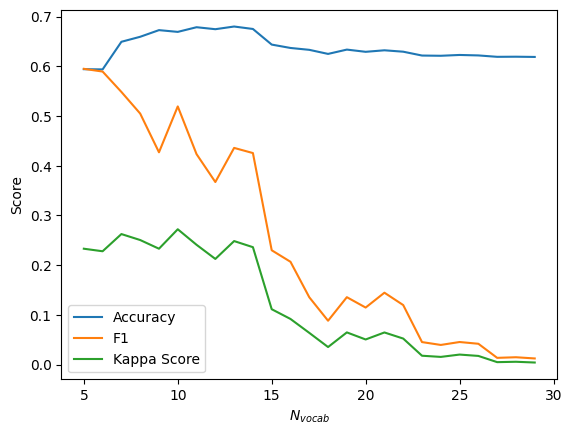

In [31]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Calibrating the N_vocab parameter to find what values gives best kappa score
df_train, df_test = burrows_read_input_json("dev-labels")
train_corpus, test_corpus = burrows_corpus_make(df_train, df_test)
accuracy,F1,kappa_score = [],[],[]
N_range = list(range(5,30))
for N_vocab in N_range:
    pred = calculate_burrows_delta(train_corpus, test_corpus,vocab_size = N_vocab)
    true_authors = [t.split()[0] for t in pred.idxmin().index]
    pred_authors = list(pred.idxmin())  
    accuracy.append(accuracy_score(true_authors,pred_authors))
    F1.append(f1_score([int(t == 'human') for t in true_authors],[int(t == 'human') for t in pred_authors]))
    kappa_score.append(cohen_kappa_score(true_authors, pred_authors))

# Plotting the calibration results
plt.plot(N_range,accuracy,label='Accuracy')
plt.plot(N_range,F1,label='F1')
plt.plot(N_range,kappa_score,label='Kappa Score')
plt.legend()
plt.xlabel('$N_{vocab}$')
plt.ylabel('Score')

In [ ]:

N_range[kappa_score.index(max(kappa_score))] # 10 is the N_vocab with highest kappa score
max(kappa_score) 


0.27215762993380443

### Explore the relationship between sentence length and type

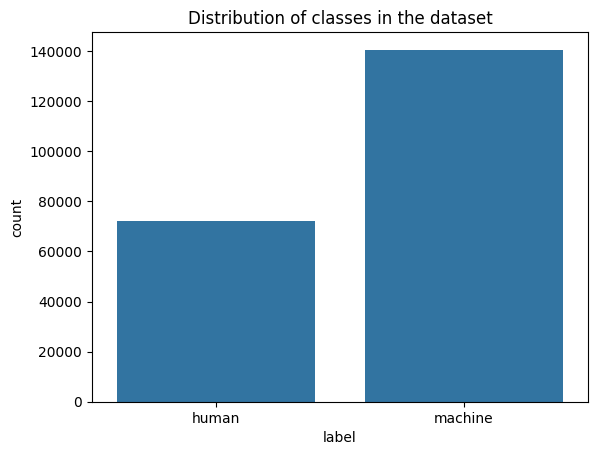

In [112]:
import seaborn as sns

sns.countplot(data=df_train, x=df_train.label)
plt.title("Distribution of classes in the dataset")
plt.show()


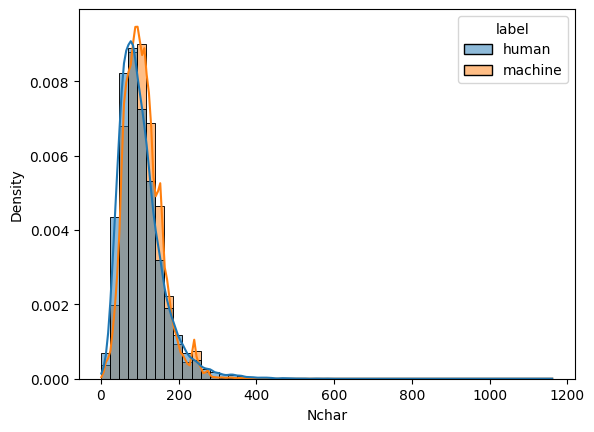

In [15]:
sns.histplot(data=df_train, x="Nchar", hue="label",bins = 50, kde = True, 
              stat = "density", common_norm=False,
             )
plt.show()


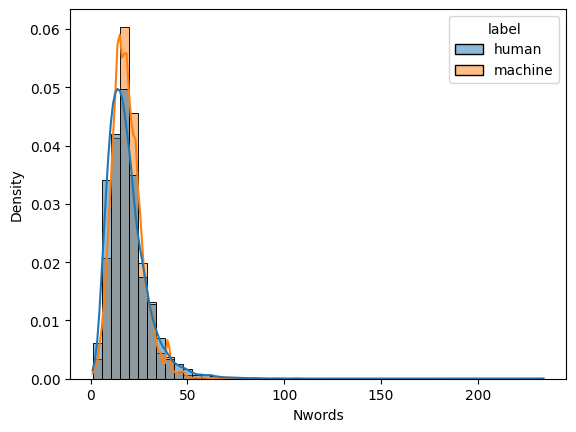

In [16]:
sns.histplot(data=df_train, x="Nwords", hue="label",bins = 50, kde = True, 
  stat = "density", common_norm=False,
)
plt.show()


# PCA On Readability Metrics

In [16]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import textstat # https://pypi.org/project/textstat/
import pandas as pd
import json



# read json files into train and test dataframes
def read_input_json(phase):

    df_train = pd.read_json('../alta2024_public_data/train.json')
    df_train = df_train.explode('sent_and_label')
    df_train = df_train.explode('sent_and_label')
    df_train = pd.DataFrame({'id':df_train['id'].iloc[1::2],
                        'domain':df_train['domain'].iloc[1::2],
                        'sent':df_train['sent_and_label'].iloc[::2].values, 
                        'label':df_train['sent_and_label'].iloc[1::2].values})                     
    df_train['index'] = df_train.groupby('id').cumcount() + 1
    df_train['id'] = df_train['id'].astype(str)  +  "-"  +  df_train['index'].astype(str) 
    df_train = df_train.drop('index', axis = 1)

    if phase == "dev-labels" :
        
        df_test = pd.read_json('../alta2024_public_data/phase1_test_with_labels.json')
        df_test = df_test.explode('sent_and_label')
        df_test = df_test.explode('sent_and_label')
        df_test = pd.DataFrame({'id':df_test['id'].iloc[1::2],
                            'domain':df_test['domain'].iloc[1::2],
                            'sent':df_test['sent_and_label'].iloc[::2].values, 
                            'label':df_test['sent_and_label'].iloc[1::2].values})
        #Generating unique IDs
        df_test['index'] = df_test.groupby('id').cumcount() + 1
        df_test['id'] = df_test['id'].astype(str)  +  "-"  +  df_test['index'].astype(str) 
        df_test = df_test.drop('index', axis = 1)


    elif phase == "dev-no-labels":

        df_test = pd.read_json('../alta2024_public_data/phase1_test_without_labels.json')
        df_test = df_test.explode('sent')
        df_test = pd.DataFrame({'id':df_test['id'],
                            'domain':df_test['domain'],
                            'sent':df_test['sent'].values})
        df_test['index'] = df_test.groupby('id').cumcount() + 1
        df_test['id'] = df_test['id'].astype(str)  +  "-"  +  df_test['index'].astype(str) 
        df_test = df_test.drop('index', axis = 1)

    elif phase == "test":

        df_test = pd.read_json('../alta2024_public_data/phase2_test_without_labels.json')
        df_test = df_test.explode('sent')
        df_test = pd.DataFrame({'id':df_test['id'],
                            'domain':df_test['domain'],
                            'sent':df_test['sent'].values})
        df_test['index'] = df_test.groupby('id').cumcount() + 1
        df_test['id'] = df_test['id'].astype(str)  +  "-"  +  df_test['index'].astype(str) 
        df_test = df_test.drop('index', axis = 1)
        df_test['label'] = ["1" for i in df_test['id']]

    else:
        print("Specify phase")
        return None

    
    return df_train, df_test

# add readability features to the dataset 
def pca_dataframes_make(df_train, df_test):

    read_df_train = df_train.copy()
    read_df_test = df_test.copy()



    sents = list(read_df_train['sent'])
    flesch_kincaid_grade,text_standard,syllable_count,flesch_reading_ease,gunning_fog= [],[],[],[],[]
    smog_index,automated_readability_index,coleman_liau_index,linsear_write_formula,dale_chall_readability_score=[],[],[],[],[]
    spache_readability,mcalpine_eflaw,reading_time,lexicon_count = [],[],[],[]
    sentence_count,char_count,letter_count,polysyllabcount,monosyllabcount=[],[],[],[],[]
    for sent in sents:
        flesch_kincaid_grade.append(textstat.flesch_kincaid_grade(sent))
        text_standard.append(textstat.text_standard(sent,float_output=True))
        syllable_count.append(textstat.syllable_count(sent))
        flesch_reading_ease.append(textstat.flesch_reading_ease(sent))
        gunning_fog.append(textstat.gunning_fog(sent))
        smog_index.append(textstat.smog_index(sent))
        automated_readability_index.append(textstat.automated_readability_index(sent))
        coleman_liau_index.append(textstat.coleman_liau_index(sent))
        linsear_write_formula.append(textstat.linsear_write_formula(sent))
        dale_chall_readability_score.append(textstat.dale_chall_readability_score(sent))
        spache_readability.append(textstat.spache_readability(sent))
        mcalpine_eflaw.append(textstat.mcalpine_eflaw(sent))
        reading_time.append(textstat.reading_time(sent, ms_per_char=14.69))
        lexicon_count.append(textstat.lexicon_count(sent, removepunct=False))
        sentence_count.append(textstat.sentence_count(sent))
        char_count.append(textstat.char_count(sent, ignore_spaces=True))
        letter_count.append(textstat.letter_count(sent, ignore_spaces=True))
        polysyllabcount.append(textstat.polysyllabcount(sent))
        monosyllabcount.append(textstat.monosyllabcount(sent))

    read_df_train['flesch_kincaid_grade'] = flesch_kincaid_grade
    read_df_train['text_standard'] = text_standard
    read_df_train['syllable_count'] = syllable_count
    read_df_train['flesch_reading_ease'] = flesch_reading_ease
    read_df_train['gunning_fog'] = gunning_fog
    read_df_train['smog_index'] = smog_index
    read_df_train['automated_readability_index'] = automated_readability_index
    read_df_train['coleman_liau_index'] = coleman_liau_index
    read_df_train['linsear_write_formula'] = linsear_write_formula
    read_df_train['dale_chall_readability_score'] = dale_chall_readability_score
    read_df_train['spache_readability'] = spache_readability
    read_df_train['mcalpine_eflaw'] = mcalpine_eflaw
    read_df_train['reading_time'] = reading_time
    read_df_train['lexicon_count'] = lexicon_count
    read_df_train['sentence_count'] = sentence_count
    read_df_train['char_count'] = char_count
    read_df_train['letter_count'] = letter_count
    read_df_train['polysyllabcount'] = polysyllabcount
    read_df_train['monosyllabcount'] = monosyllabcount
    read_df_train['Nchar'] = read_df_train['sent'].str.len()
    read_df_train['Nwords'] = read_df_train['sent'].str.split().str.len()






    sents = list(read_df_test['sent'])
    flesch_kincaid_grade,text_standard,syllable_count,flesch_reading_ease,gunning_fog= [],[],[],[],[]
    smog_index,automated_readability_index,coleman_liau_index,linsear_write_formula,dale_chall_readability_score=[],[],[],[],[]
    spache_readability,mcalpine_eflaw,reading_time,lexicon_count = [],[],[],[]
    sentence_count,char_count,letter_count,polysyllabcount,monosyllabcount=[],[],[],[],[]

    for sent in sents:
        flesch_kincaid_grade.append(textstat.flesch_kincaid_grade(sent))
        text_standard.append(textstat.text_standard(sent,float_output=True))
        syllable_count.append(textstat.syllable_count(sent))
        flesch_reading_ease.append(textstat.flesch_reading_ease(sent))
        gunning_fog.append(textstat.gunning_fog(sent))
        smog_index.append(textstat.smog_index(sent))
        automated_readability_index.append(textstat.automated_readability_index(sent))
        coleman_liau_index.append(textstat.coleman_liau_index(sent))
        linsear_write_formula.append(textstat.linsear_write_formula(sent))
        dale_chall_readability_score.append(textstat.dale_chall_readability_score(sent))
        spache_readability.append(textstat.spache_readability(sent))
        mcalpine_eflaw.append(textstat.mcalpine_eflaw(sent))
        reading_time.append(textstat.reading_time(sent, ms_per_char=14.69))
        lexicon_count.append(textstat.lexicon_count(sent, removepunct=False))
        sentence_count.append(textstat.sentence_count(sent))
        char_count.append(textstat.char_count(sent, ignore_spaces=True))
        letter_count.append(textstat.letter_count(sent, ignore_spaces=True))
        polysyllabcount.append(textstat.polysyllabcount(sent))
        monosyllabcount.append(textstat.monosyllabcount(sent))

    read_df_test['flesch_kincaid_grade'] = flesch_kincaid_grade
    read_df_test['text_standard'] = text_standard
    read_df_test['syllable_count'] = syllable_count
    read_df_test['flesch_reading_ease'] = flesch_reading_ease
    read_df_test['gunning_fog'] = gunning_fog
    read_df_test['smog_index'] = smog_index
    read_df_test['automated_readability_index'] = automated_readability_index
    read_df_test['coleman_liau_index'] = coleman_liau_index
    read_df_test['linsear_write_formula'] = linsear_write_formula
    read_df_test['dale_chall_readability_score'] = dale_chall_readability_score
    read_df_test['spache_readability'] = spache_readability
    read_df_test['mcalpine_eflaw'] = mcalpine_eflaw
    read_df_test['reading_time'] = reading_time
    read_df_test['lexicon_count'] = lexicon_count
    read_df_test['sentence_count'] = sentence_count
    read_df_test['char_count'] = char_count
    read_df_test['letter_count'] = letter_count
    read_df_test['polysyllabcount'] = polysyllabcount
    read_df_test['monosyllabcount'] = monosyllabcount
    read_df_test['Nchar'] = read_df_test['sent'].str.len()
    read_df_test['Nwords'] = read_df_test['sent'].str.split().str.len()

    return read_df_train, read_df_test

# scale the passed in datasets before PCA
def pca_scaled_dataframes_make(read_df_train, read_df_test, test_labels):

    # Creating train df
    pca_read_df_train = read_df_train.iloc[:,[1]+list(range(4,read_df_train.shape[1
    ]))].copy()
    pca_read_df_train['domain'] = [0 if domain == "news" else 1 for domain in pca_read_df_train['domain']]

    if test_labels:
        index = 4
    else:
        index = 3

    pca_read_df_test = read_df_test.iloc[:,[1]+list(range(index,read_df_test.shape[1
    ]))].copy()
    pca_read_df_test['domain'] = [0 if domain == "news" else 1 for domain in pca_read_df_test['domain']]


    scaling=StandardScaler()
    scaling.fit(pca_read_df_train)

    Scaled_data=scaling.transform(pca_read_df_train)
    test_Scaled_data=scaling.transform(pca_read_df_test)

    return Scaled_data , test_Scaled_data

# Perform PCA on scaled data
def pca_knn_predict(Scaled_data, test_Scaled_data, read_df_train):

    pca=PCA(n_components =7)

    pca.fit(Scaled_data)
    transformed_read_df_train=pca.transform(Scaled_data)
    test_transform = pca.transform(test_Scaled_data)

    pca_knn = KNeighborsClassifier(n_neighbors=5)
    pca_knn_x = transformed_read_df_train
    pca_knn_model = pca_knn.fit(pca_knn_x, read_df_train['label'])
    pca_knn_pred = pca_knn_model.predict(test_transform)
    pca_knn_pred = list(pca_knn_pred)

    return pca_knn_pred

# Perform Scaling + PCA + KNN using pipeline to chain all these steps together
def pipelined_pca(read_df_train, read_df_test, test_labels):

    X_train = read_df_train.iloc[:,[1]+list(range(4,read_df_train.shape[1]))].copy()
    #encoding domain feature
    X_train['domain'] = [0 if domain == "news" else 1 for domain in X_train['domain']]
    Y_train = read_df_train['label']

    if test_labels:
        index = 4
    else:
        index = 3

    X_test = read_df_test.iloc[:,[1]+list(range(index,read_df_test.shape[1
    ]))].copy()
    X_test['domain'] = [0 if domain == "news" else 1 for domain in X_test['domain']]

    model = make_pipeline( StandardScaler(), PCA(n_components =7), KNeighborsClassifier(n_neighbors = 5) )
    model.fit(X_train, Y_train)
    pipeline_pca_pred = list(model.predict(X_test))
    return pipeline_pca_pred

# Extract prediction probabilities instead of hard labels. Returns probability of the sentence belonging to machine class
def pipelined_pca_proba(read_df_train, read_df_test, test_labels):

    X_train = read_df_train.iloc[:,[1]+list(range(4,read_df_train.shape[1
    ]))].copy()
    #encoding domain feature
    X_train['domain'] = [0 if domain == "news" else 1 for domain in X_train['domain']]
    Y_train = read_df_train['label']

    if test_labels:
        index = 4
    else:
        index = 3

    X_test = read_df_test.iloc[:,[1]+list(range(index,read_df_test.shape[1
    ]))].copy()
    X_test['domain'] = [0 if domain == "news" else 1 for domain in X_test['domain']]

    model = make_pipeline( StandardScaler(), PCA(n_components =7), KNeighborsClassifier(n_neighbors = 5, weights='distance' ) )
    model.fit(X_train, Y_train)
    pipeline_pca_pred = list(model.predict_proba(X_test))
    return pipeline_pca_pred

# Returns kappa score of predicted label vs true label
def kappa_score_pca(pca_knn_pred , df_test, phase):
    if phase != 'dev-labels':
        print("No test labels available. Hence no kappa scores")
    else:
        print("Kappa score is ", cohen_kappa_score(pca_knn_pred,df_test['label']))

# Create json file to submit for the competition
def make_json(preds, df_test):

    df_test['label'] = preds

    df = df_test

    # Create a dictionary to hold the final JSON structure
    json_data = []

    # Group by the id (before the hyphen) and aggregate sentences
    for group_id, group in df.groupby(df['id'].str.split('-').str[0]):
        entry = {
            "id": int(group_id.split('-')[0]),  # Extract and convert group id to integer
            "sent_and_label": [],
            "domain": group['domain'].iloc[0]  # Assuming all rows in the group have the same domain
        }
        
        # Add sentences and their labels to the "sent_and_label" list
        for _, row in group.iterrows():
            entry["sent_and_label"].append([row['sent'], row['label']])
        
        json_data.append(entry)

    # Convert to JSON and save to a file
    with open('answer.json', 'w' , encoding='utf-8') as json_file:
        json.dump(json_data, json_file, indent=4,ensure_ascii=False)

    print("JSON file with labels created successfully!")

# Wrapper function to obtain label predictions 
def pca_all_steps(phase, is_labelled):

    df_train, df_test = read_input_json(phase)
    read_df_train, read_df_test = pca_dataframes_make(df_train, df_test) 
    scaled_train_df, scaled_val_df = pca_scaled_dataframes_make(read_df_train, read_df_test,is_labelled)
    pca_knn_pred = pca_knn_predict(scaled_train_df, scaled_val_df, read_df_train )
    kappa_score_pca(pca_knn_pred,df_test,phase)
    make_json(pca_knn_pred, df_test)
    return pca_knn_pred

# wrapper function to obtain predicted labels. This uses pipleline module.
def pipelined_pca_all_steps(phase,is_labelled):

    df_train, df_test = read_input_json(phase)
    read_df_train, read_df_test = pca_dataframes_make(df_train, df_test) 
    pca_preds = pipelined_pca(read_df_train, read_df_test, is_labelled)
    kappa_score_pca(pca_preds,df_test,phase)
    make_json(pca_preds, df_test)
    return pca_preds

# wrapper function to get prediction probabilities instead of labels. Returns probabaility of the sentence belonging to 'machine' class
def pca_machine_proba(phase = "dev-labels", is_labelled = True ):
    df_train, df_test = read_input_json(phase)
    read_df_train, read_df_test = pca_dataframes_make(df_train, df_test) 
    pca_preds = pipelined_pca_proba(read_df_train, read_df_test, is_labelled)
    pca_machine_proba = [x[1] for x in pca_preds]
    return pca_machine_proba







### PCA Exploration and Plots

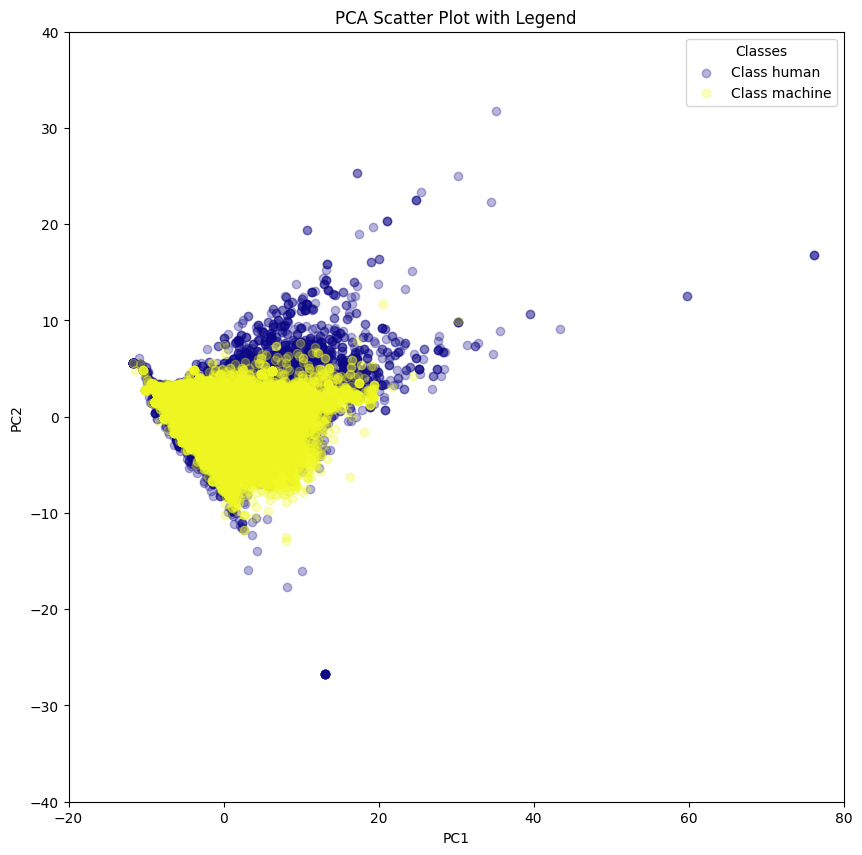

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# Read in data and convert to a form fit for PCA by encoding all features numeric
df_train, df_test = read_input_json("dev-labels")
read_df_train, read_df_test = pca_dataframes_make(df_train, df_test)
X_train = read_df_train.iloc[:,[1]+list(range(4,read_df_train.shape[1]))].copy()
X_train['domain'] = [0 if domain == "news" else 1 for domain in X_train['domain']]

# Make pipeline with scaling and PCA and obtained transformed dataframe 
model = make_pipeline( StandardScaler(), PCA())
transformed_values = model.fit_transform(X_train)
transformed_train =  pd.DataFrame(transformed_values).iloc[ :, :2]

# Sample Data for Visualization (x and y from PCA)
plt.figure(figsize=(10,10))

# Get unique labels and corresponding colors
unique_labels = np.unique(read_df_train['label'])
colors = plt.cm.plasma(np.linspace(0, 1, len(unique_labels)))  # Generate colors

# Plot PC1 and PC2 by labels
for label, color in zip(unique_labels, colors):
    plt.scatter(transformed_train.iloc[list(read_df_train['label']==label), 0],
                transformed_train.iloc[list(read_df_train['label'] == label), 1],
                label=f"Class {label}", color=color, alpha=0.3)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter Plot with Legend')

plt.xlim([-20, 80])  # Set x-axis range 
plt.ylim([-40, 40])  # Set y-axis range 

# Add the legend
plt.legend(title='Classes', loc='best')  
plt.show()


In [ ]:
pca = model.named_steps['pca']
explained_variance_ratio = pca.explained_variance_ratio_
np.sum(explained_variance_ratio[:7]) # First 7 components explain 96% variance in the data

0.963791576866341

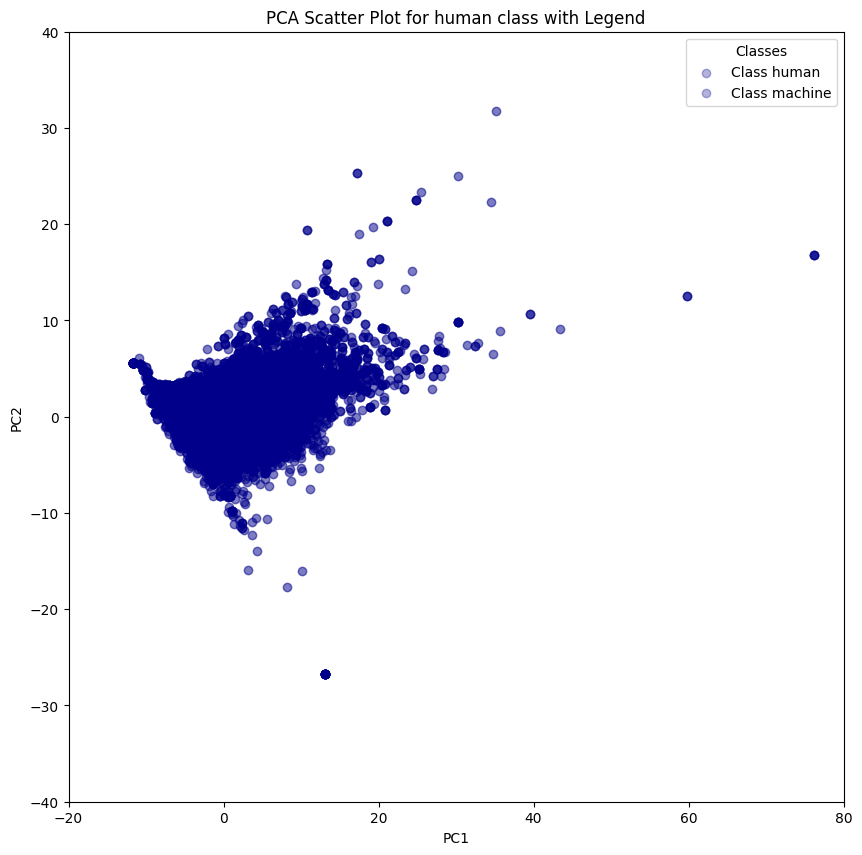

In [ ]:
# Generating PC1-PC2 plots for human class

plt.figure(figsize=(10,10))

# Get unique labels and corresponding colors
unique_labels = np.unique(read_df_train['label'])
colors = plt.cm.plasma(np.linspace(0, 1, len(unique_labels)))  # Generate colors

# Plot PC1 and PC2 by labels
for label, color in zip(unique_labels, colors):
    plt.scatter(transformed_train.iloc[list(read_df_train['label'] == "human"), 0],
                transformed_train.iloc[list(read_df_train['label'] == "human"), 1],
                label=f"Class {label}", color='darkblue', alpha=0.3)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter Plot for human class with Legend')

plt.xlim([-20, 80])  # Set x-axis range 
plt.ylim([-40, 40])  # Set y-axis range 

# Add the legend
plt.legend(title='Classes', loc='best') 
plt.show()

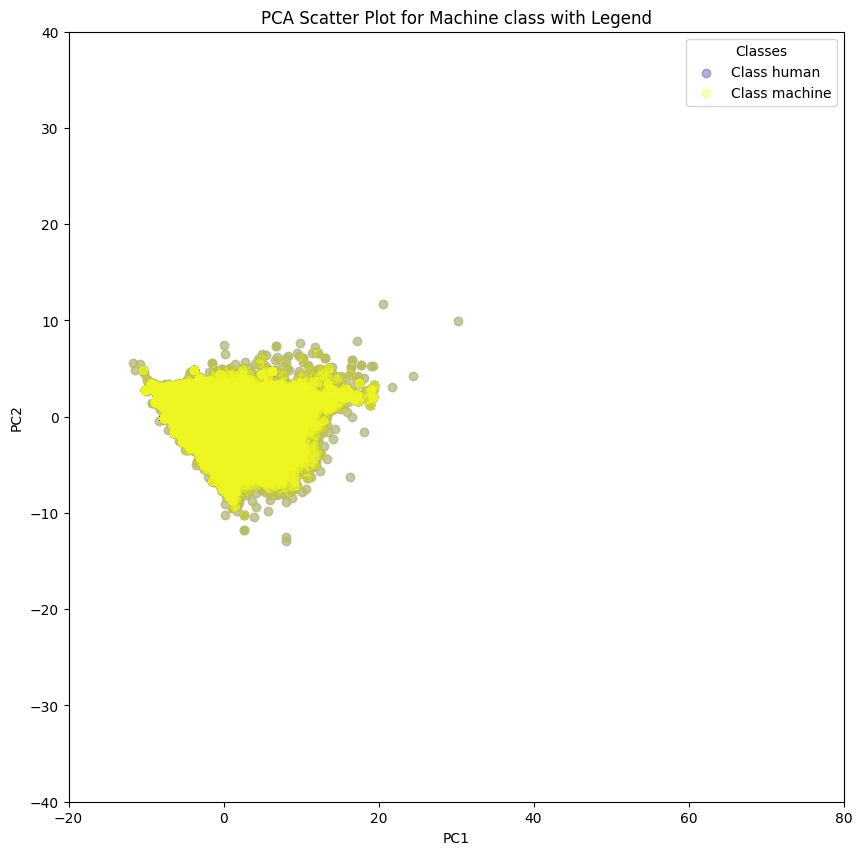

In [ ]:
# Generating PC1-PC2 plots for machine class

plt.figure(figsize=(10,10))

# Get unique labels and corresponding colors
unique_labels = np.unique(read_df_train['label'])
colors = plt.cm.plasma(np.linspace(0, 1, len(unique_labels)))  # Generate colors

# Plot PC1 and PC2 by labels
for label, color in zip(unique_labels, colors):
    plt.scatter(transformed_train.iloc[list(read_df_train['label'] == "machine"), 0],
                transformed_train.iloc[list(read_df_train['label'] == "machine"), 1],
                label=f"Class {label}", color=color, alpha=0.3)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter Plot for Machine class with Legend')

plt.xlim([-20, 80])  # Set x-axis range 
plt.ylim([-40, 40])  # Set y-axis range 

# Add the legend
plt.legend(title='Classes', loc='best')  
plt.show()

# TF - IDF 

In [17]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt


# Function to return predicted labels using TF-IDF+ Naive Bayes
def tfidf_predict(df_train, df_test ):

    # Sample data (replace with your actual data)
    X_train = list(df_train['sent'])
    Y_train = df_train['label']
    X_test = list(df_test['sent'])

    model = make_pipeline(TfidfVectorizer(max_features=27000), ComplementNB())
    model.fit(X_train, Y_train)
    tfidf_preds = model.predict(X_test)

    return list(tfidf_preds)

# Function to return proabbaility score  using TF-IDF+ Naive Bayes. Returns probabaility that sentence belongs to 'machine' class
def tfidf_predict_proba(df_train, df_test ):

    # Sample data (replace with your actual data)
    X_train = list(df_train['sent'])
    Y_train = df_train['label']
    X_test = list(df_test['sent'])

    model = make_pipeline(TfidfVectorizer(max_features=27000), ComplementNB())
    model.fit(X_train, Y_train)
    tfidf_preds = model.predict_proba(X_test)

    return list(tfidf_preds)


def kappa_score_tfidf(tfidf_preds , df_test, phase):
    if phase != 'dev-labels':
        print("No test labels available. Hence no kappa scores")
    else:
        print("Kappa score is ", cohen_kappa_score(tfidf_preds,df_test['label']))

# Wrapper function to obtain predicted labels
def tfidf_all_steps(phase):
    df_train, df_test = read_input_json(phase)
    tfidf_preds = tfidf_predict(df_train, df_test )
    kappa_score_tfidf(tfidf_preds , df_test, phase)
    return tfidf_preds

# Wrapper function to obtain probability score
def tfidf_machine_proba(phase="dev-labels"):
    df_train, df_test = read_input_json(phase) 
    tfidf_proba = tfidf_predict_proba(df_train, df_test )   
    tfidf_proba_machine =  [x[1] for x in tfidf_proba]
    return tfidf_proba_machine

### Finding best parameter for tfidf-vectorizer

max_features: 1, Mean Kappa Score: 0.0000
max_features: 1001, Mean Kappa Score: 0.4915
max_features: 2001, Mean Kappa Score: 0.5288
max_features: 3001, Mean Kappa Score: 0.5481
max_features: 4001, Mean Kappa Score: 0.5556
max_features: 5001, Mean Kappa Score: 0.5605
max_features: 6001, Mean Kappa Score: 0.5642
max_features: 7001, Mean Kappa Score: 0.5675
max_features: 8001, Mean Kappa Score: 0.5694
max_features: 9001, Mean Kappa Score: 0.5735
max_features: 10001, Mean Kappa Score: 0.5754
max_features: 11001, Mean Kappa Score: 0.5782
max_features: 12001, Mean Kappa Score: 0.5793
max_features: 13001, Mean Kappa Score: 0.5807
max_features: 14001, Mean Kappa Score: 0.5820
max_features: 15001, Mean Kappa Score: 0.5832
max_features: 16001, Mean Kappa Score: 0.5846
max_features: 17001, Mean Kappa Score: 0.5856
max_features: 18001, Mean Kappa Score: 0.5868
max_features: 19001, Mean Kappa Score: 0.5878
max_features: 20001, Mean Kappa Score: 0.5887
max_features: 21001, Mean Kappa Score: 0.5893
m

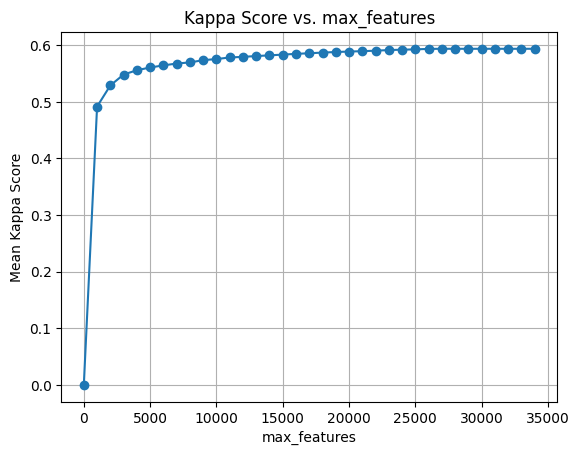

In [108]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt


sentences = list(df_train['sent'])
labels = df_train['label']

# Define the kappa scorer
kappa_scorer = make_scorer(cohen_kappa_score)

# Function to perform CV with kappa score
def evaluate_max_features(max_features):
    model = make_pipeline(
        TfidfVectorizer(max_features=max_features),
        ComplementNB()
    )
    scores = cross_val_score(model, sentences, labels, cv=5, scoring=kappa_scorer)
    return scores.mean()

# Range of max_features to evaluate
max_features_list = list(range(1,35000,1000))
results = {}

# Evaluate each max_features value
for max_features in max_features_list:
    mean_kappa = evaluate_max_features(max_features)
    results[max_features] = mean_kappa
    print(f"max_features: {max_features}, Mean Kappa Score: {mean_kappa:.4f}")

# Find the best max_features
best_max_features = max(results, key=results.get)
print(f"\nBest max_features: {best_max_features}, Highest Mean Kappa Score: {results[best_max_features]:.4f}")

# Plot the results
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.xlabel('max_features')
plt.ylabel('Mean Kappa Score')
plt.title('Kappa Score vs. max_features')
plt.grid(True)
plt.show()




In [109]:
# Based on the above graph, we choose max_features to be 27,000

### Cross Entropy

In [ ]:
# To extract dataframe from cross-entropy prediciton json file
df_cross = pd.read_json('../json_files/answer_lewis.json')
df_cross = df_cross.explode('sent_and_label')
df_cross = df_cross.explode('sent_and_label')
df_cross = pd.DataFrame({'id':df_cross['id'].iloc[1::2],
                    'domain':df_cross['domain'].iloc[1::2],
                    'sent':df_cross['sent_and_label'].iloc[::2].values, 
                    'label':df_cross['sent_and_label'].iloc[1::2].values})
#Generating unique IDs
df_cross['index'] = df_cross.groupby('id').cumcount() + 1
df_cross['id'] = df_cross['id'].astype(str)  +  "-"  +  df_cross['index'].astype(str) 
df_cross = df_cross.drop('index', axis = 1)

df_cross.index = df_cross['id']
df_cross = df_cross.reindex(df_test['id'])



### CoreNLP

In [ ]:
# Extracting dataframe from json file of coreNLP predictions

df_bao = pd.read_json('../json_files/answer_bao_phase1.json')
df_bao = df_bao.explode('sent_and_label')
df_bao = df_bao.explode('sent_and_label')
df_bao = pd.DataFrame({'id':df_bao['id'].iloc[1::2],
                    'domain':df_bao['domain'].iloc[1::2],
                    'sent':df_bao['sent_and_label'].iloc[::2].values, 
                    'label':df_bao['sent_and_label'].iloc[1::2].values})
#Generating unique IDs
df_bao['index'] = df_bao.groupby('id').cumcount() + 1
df_bao['id'] = df_bao['id'].astype(str)  +  "-"  +  df_bao['index'].astype(str) 
df_bao = df_bao.drop('index', axis = 1)

df_bao.index = df_bao['id']
df_bao = df_bao.reindex(df_test['id'])

corenlp_preds_2 = list(df_bao['label'])


In [34]:
corenlp_preds_2

['machine',
 'human',
 'human',
 'human',
 'machine',
 'machine',
 'machine',
 'machine',
 'machine',
 'machine',
 'machine',
 'human',
 'machine',
 'machine',
 'human',
 'machine',
 'human',
 'machine',
 'machine',
 'human',
 'machine',
 'human',
 'human',
 'human',
 'human',
 'machine',
 'machine',
 'machine',
 'machine',
 'human',
 'human',
 'human',
 'machine',
 'machine',
 'machine',
 'human',
 'machine',
 'machine',
 'human',
 'human',
 'human',
 'human',
 'machine',
 'machine',
 'human',
 'machine',
 'human',
 'machine',
 'machine',
 'machine',
 'human',
 'machine',
 'machine',
 'machine',
 'machine',
 'machine',
 'human',
 'human',
 'human',
 'machine',
 'machine',
 'human',
 'human',
 'machine',
 'machine',
 'machine',
 'machine',
 'machine',
 'machine',
 'machine',
 'human',
 'human',
 'machine',
 'machine',
 'human',
 'human',
 'human',
 'human',
 'machine',
 'machine',
 'machine',
 'machine',
 'human',
 'human',
 'human',
 'human',
 'human',
 'machine',
 'machine',
 'human'

# MetaModels

### Weighted Vote

In [ ]:
# Function to encode labels to numbers
def encode_labels(label):
    if label == "machine":
        return 1
    else:
        return 0

# Function to decode numbers to labels
def decode_labels(num):
    if num >= 0.5:
        return "machine"
    else:
        return "human"

# Returns weighted vote model predictions
def weighted_voting(preds,weights):

    pred_list = []
    for pred in preds:
        pred_list.append(pred)

    weight_list = []
    for weight in weights:
        weight_list.append(weight)

    combined_array = np.array(pred_list).T
    encode_func = np.vectorize(encode_labels)
    combined_array = encode_func(combined_array)

    weights = np.array(weight_list)
    weights = (weights/np.sum(weights)).T

    weighted_labels = np.dot(combined_array, weights)
    decode_func = np.vectorize(decode_labels)
    final_preds = list(decode_func(weighted_labels))

    return final_preds



In [262]:
preds = [corenlp_preds,cross_preds,burrows_preds,pca_preds,tfidf_preds]
weights = [0.39,0.67,0.27,0.43,0.51]
final_preds = weighted_voting(preds,weights)
df_train, df_test = read_input_json('dev-no-labels')
make_json(final_preds, df_test)



JSON file with labels created successfully!


### Random Forest Tuning

In [ ]:
# Using base model preds to create a dataframe to input into metamodels for phase 2 submission

pca_phase_2 = pipelined_pca_all_steps('test',True)
burrows_phase_2 = burrows_all_steps('test')
tfidf_phase_2 = tfidf_all_steps('test')

df_cross = pd.read_json('../json_files/lewis_phase2.json')
df_cross = df_cross.explode('sent_and_label')
df_cross = df_cross.explode('sent_and_label')
df_cross = pd.DataFrame({'id':df_cross['id'].iloc[1::2],
                    'domain':df_cross['domain'].iloc[1::2],
                    'sent':df_cross['sent_and_label'].iloc[::2].values, 
                    'label':df_cross['sent_and_label'].iloc[1::2].values})
# #Generating unique IDs
df_cross['index'] = df_cross.groupby('id').cumcount() + 1
df_cross['id'] = df_cross['id'].astype(str)  +  "-"  +  df_cross['index'].astype(str) 
df_cross = df_cross.drop('index', axis = 1)
df_cross.index = df_cross['id']

df_train, df_test = read_input_json('test')
df_cross = df_cross.reindex(df_test['id'])
cross_pred_phase_2 = list(df_cross['label'])

preds = [burrows_phase_2, pca_phase_2, tfidf_phase_2, cross_pred_phase_2]
col_names = ['burrows', 'pca', 'tfidf', 'cross_entropy']

phase_1_test_df = combined_encoded_features_df(preds,col_names) # submission with this

No test labels available. Hence no kappa scores
JSON file with labels created successfully!


C:\Users\joelj\AppData\Roaming\Python\Python39\site-packages\faststylometry\burrows_delta.py:159: RuntimeWarning: invalid value encountered in divide
  corpus.token_proportions = corpus.token_counts_by_author / corpus.total_token_counts_by_author
C:\Users\joelj\AppData\Local\Temp\ipykernel_1608\7672506.py:98: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  burrows_pred_series = burrows_pred_df.idxmin().copy()


No test labels available. Hence no kappa scores
JSON file with labels created successfully!
No test labels available. Hence no kappa scores


In [ ]:
# Using base model preds to create a dataframe to input into metamodels for phase 1 submission

pca_phase_1 = pipelined_pca_all_steps('dev-labels',True)
burrows_phase_1 = burrows_all_steps('dev-labels')
tfidf_phase_1 = tfidf_all_steps('dev-labels')

df_cross = pd.read_json('../json_files/answer_lewis.json')
df_cross = df_cross.explode('sent_and_label')
df_cross = df_cross.explode('sent_and_label')
df_cross = pd.DataFrame({'id':df_cross['id'].iloc[1::2],
                    'domain':df_cross['domain'].iloc[1::2],
                    'sent':df_cross['sent_and_label'].iloc[::2].values, 
                    'label':df_cross['sent_and_label'].iloc[1::2].values})
#Generating unique IDs
df_cross['index'] = df_cross.groupby('id').cumcount() + 1
df_cross['id'] = df_cross['id'].astype(str)  +  "-"  +  df_cross['index'].astype(str) 
df_cross = df_cross.drop('index', axis = 1)


df_train, df_test = read_input_json('dev-labels')
df_cross.index = df_cross['id']
df_cross = df_cross.reindex(df_test['id'])
cross_pred_phase_1 = list(df_cross['label'])

preds = [burrows_phase_1, pca_phase_1, tfidf_phase_1, cross_pred_phase_1]
col_names = ['burrows', 'pca', 'tfidf', 'cross_entropy']


phase_1_test_df = combined_encoded_features_df(preds,col_names) # Preliminary test with this



Kappa score is  0.4314124072633272
JSON file with labels created successfully!


C:\Users\joelj\AppData\Roaming\Python\Python39\site-packages\faststylometry\burrows_delta.py:159: RuntimeWarning: invalid value encountered in divide
  corpus.token_proportions = corpus.token_counts_by_author / corpus.total_token_counts_by_author
C:\Users\joelj\AppData\Local\Temp\ipykernel_21324\7672506.py:98: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  burrows_pred_series = burrows_pred_df.idxmin().copy()


Kappa score is  0.273345203844493
JSON file with labels created successfully!
Kappa score is  0.5122926582947696


In [8]:

### Create DF for RF to train
pred_1 = burrows_ensemble_train_predict('dev-labels')
pred_2 = pca_ensemble_train_predict('dev-labels', True)
pred_3 = tfidf_ensemble_train_predict('dev-labels')

preds = [pred_1, pred_2, pred_3, pred_4]
col_names = ['burrows', 'pca', 'tfidf', 'cross_entropy']

encoded_df = combined_encoded_features_df(preds,col_names)
df_train, df_test = read_input_json('dev-labels')
mini_train, valid_set = train_test_split(df_train,test_size=0.5,random_state=100)


phase_0_train_df = get_combined_df (encoded_df, valid_set['label']) ### Tune with this


C:\Users\joelj\AppData\Roaming\Python\Python39\site-packages\faststylometry\burrows_delta.py:159: RuntimeWarning: invalid value encountered in divide
  corpus.token_proportions = corpus.token_counts_by_author / corpus.total_token_counts_by_author
C:\Users\joelj\AppData\Local\Temp\ipykernel_21324\7672506.py:98: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  burrows_pred_series = burrows_pred_df.idxmin().copy()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, cohen_kappa_score

kappa_scorer = make_scorer(cohen_kappa_score)

rf = RandomForestClassifier(random_state=42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt','log2', None, 2, 4,6]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,5,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,4,10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 500, cv = 3, scoring=kappa_scorer, verbose=4, random_state=42, n_jobs = -1)

# # Fit the random search model

rf_random.fit( phase_0_train_df.iloc[:, :-1], phase_0_train_df.iloc[:, -1])

In [18]:
random_grid

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000],
 'max_features': ['sqrt', 'log2', None, 2, 4, 6],
 'max_depth': [10, 32, 55, 77, 100, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4, 10],
 'bootstrap': [True, False]}

In [19]:
params

{'n_estimators': 522,
 'min_samples_split': 5,
 'min_samples_leaf': 10,
 'max_features': 'log2',
 'max_depth': 10,
 'bootstrap': True}

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer, cohen_kappa_score


kappa_scorer = make_scorer(cohen_kappa_score)

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [90,100,110,None],
    'max_features': ['sqrt'],
    'min_samples_leaf': [3],
    'min_samples_split': [3],
    'n_estimators': [955,1055,1155,1255]
}
# Create a based model
rf = RandomForestClassifier(random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2, scoring=kappa_scorer)

grid_search.fit( final_df.iloc[:, :-1], final_df.iloc[:, -1])

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [90, 100, 110, None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [3],
                         'min_samples_split': [3],
                         'n_estimators': [955, 1055, 1155, 1255]},
             scoring=make_scorer(cohen_kappa_score), verbose=2)

In [ ]:
grid_search.best_params_ # we obtain the best parameters obtained from tuning

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 955}

In [ ]:
best_grid = grid_search.best_estimator_
best_grid

RandomForestClassifier(max_depth=90, min_samples_leaf=3, min_samples_split=3,
                       n_estimators=955, random_state=42)

In [ ]:
pred_1 = burrows_ensemble_train_predict('dev-labels')
pred_2 = pca_ensemble_train_predict('dev-labels', True)
pred_3 = tfidf_ensemble_train_predict('dev-labels')

preds = [pred_1, pred_2, pred_3, pred_4]
col_names = ['burrows', 'pca', 'tfidf', 'cross_entropy']

encoded_df = combined_encoded_features_df(preds,col_names)
df_train, df_test = read_input_json('dev-labels')
mini_train, valid_set = train_test_split(df_train,test_size=0.5,random_state=100)
final_df = get_combined_df (encoded_df, valid_set['label'])

### Phase 2 Preds


In [49]:
burrows_preds_2 = burrows_all_steps("test")
pca_preds_2 = pipelined_pca_all_steps("test", True)
tfidf_preds_2 = tfidf_all_steps("test")


C:\Users\joelj\AppData\Roaming\Python\Python39\site-packages\faststylometry\burrows_delta.py:159: RuntimeWarning: invalid value encountered in divide
  corpus.token_proportions = corpus.token_counts_by_author / corpus.total_token_counts_by_author
C:\Users\joelj\AppData\Local\Temp\ipykernel_1608\7672506.py:98: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  burrows_pred_series = burrows_pred_df.idxmin().copy()


No test labels available. Hence no kappa scores
JSON file with labels created successfully!
No test labels available. Hence no kappa scores
JSON file with labels created successfully!
No test labels available. Hence no kappa scores


In [51]:
df_train, df_test = read_input_json('test')

In [ ]:
df_cross = pd.read_json('../json_files/lewis_phase2.json')
df_cross = df_cross.explode('sent_and_label')
df_cross = df_cross.explode('sent_and_label')
df_cross = pd.DataFrame({'id':df_cross['id'].iloc[1::2],
                    'domain':df_cross['domain'].iloc[1::2],
                    'sent':df_cross['sent_and_label'].iloc[::2].values, 
                    'label':df_cross['sent_and_label'].iloc[1::2].values})
#Generating unique IDs
df_cross['index'] = df_cross.groupby('id').cumcount() + 1
df_cross['id'] = df_cross['id'].astype(str)  +  "-"  +  df_cross['index'].astype(str) 
df_cross = df_cross.drop('index', axis = 1)

df_cross.index = df_cross['id']
df_cross = df_cross.reindex(df_test['id'])
cross_pred_2 = list(df_cross['label'])

In [ ]:
def combined_encoded_features_df(preds : list, col_names : list):

    pred_list = []
    for pred in preds:
        pred_list.append(pred)

    combined_array = np.array(pred_list).T
    combined_df = pd.DataFrame(combined_array, columns = col_names)

    encoded_df = pd.get_dummies(combined_df[col_names])
    return encoded_df #returns encoded combined df

def get_combined_df (encoded_df, label: pd.Series):

    label = pd.Series(list(label), name = 'label', index=list(range(0,encoded_df.shape[0])))
    encoded_df = pd.concat([encoded_df, label], axis=1)
    return encoded_df

preds = [burrows_preds_2, pca_preds_2, tfidf_preds_2, cross_pred_2]
col_names = ['burrows', 'pca', 'tfidf', 'cross_entropy']

encoded_df = combined_encoded_features_df(preds,col_names)


In [56]:
rf_preds_2 = best_grid.predict(encoded_df)

In [59]:

make_json(list(rf_preds_2), df_test)

JSON file with labels created successfully!


#### Weighted vote

In [ ]:
df_train, df_test = read_input_json('dev-labels')

burrows_preds_2 = burrows_all_steps("dev-labels")
pca_preds_2 = pipelined_pca_all_steps("dev-labels", True)
tfidf_preds_2 = tfidf_all_steps("dev-labels")

df_cross = pd.read_json('../json_files/answer_lewis.json')
df_cross = df_cross.explode('sent_and_label')
df_cross = df_cross.explode('sent_and_label')
df_cross = pd.DataFrame({'id':df_cross['id'].iloc[1::2],
                    'domain':df_cross['domain'].iloc[1::2],
                    'sent':df_cross['sent_and_label'].iloc[::2].values, 
                    'label':df_cross['sent_and_label'].iloc[1::2].values})
#Generating unique IDs
df_cross['index'] = df_cross.groupby('id').cumcount() + 1
df_cross['id'] = df_cross['id'].astype(str)  +  "-"  +  df_cross['index'].astype(str) 
df_cross = df_cross.drop('index', axis = 1)

df_cross.index = df_cross['id']
df_cross = df_cross.reindex(df_test['id'])

cross_pred_2 = list(df_cross['label'])

C:\Users\joelj\AppData\Roaming\Python\Python39\site-packages\faststylometry\burrows_delta.py:159: RuntimeWarning: invalid value encountered in divide
  corpus.token_proportions = corpus.token_counts_by_author / corpus.total_token_counts_by_author
C:\Users\joelj\AppData\Local\Temp\ipykernel_21324\7672506.py:98: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  burrows_pred_series = burrows_pred_df.idxmin().copy()


Kappa score is  0.273345203844493
JSON file with labels created successfully!
Kappa score is  0.4314124072633272
JSON file with labels created successfully!
Kappa score is  0.5122926582947696


In [38]:
preds = [corenlp_preds_2, cross_pred_2,burrows_preds_2,pca_preds_2,tfidf_preds_2,rf_preds_phase1]
weights = [0.39, 0.67,0.27,0.43,0.51,0.68] #0.39
final_preds = weighted_voting(preds,weights)
df_train, df_test = read_input_json('dev-labels')
make_json(final_preds, df_test)

JSON file with labels created successfully!


# Making JSON

In [ ]:
import pandas as pd
import json

# used to prepare json files to submit
def make_json(preds, df_test):

    df_test['label'] = preds

    df = df_test

    # Create a dictionary to hold the final JSON structure
    json_data = []

    # Group by the id (before the hyphen) and aggregate sentences
    for group_id, group in df.groupby(df['id'].str.split('-').str[0]):
        entry = {
            "id": int(group_id.split('-')[0]),  # Extract and convert group id to integer
            "sent_and_label": [],
            "domain": group['domain'].iloc[0]  # Assuming all rows in the group have the same domain
        }
        
        # Add sentences and their labels to the "sent_and_label" list
        for _, row in group.iterrows():
            entry["sent_and_label"].append([row['sent'], row['label']])
        
        json_data.append(entry)

    # Convert to JSON and save to a file
    with open('../json_files/answer.json', 'w' , encoding='utf-8') as json_file:
        json.dump(json_data, json_file, indent=4,ensure_ascii=False)

    print("JSON file with labels created successfully!")


# EXPERIMENT

In [ ]:
# 1. Split train data into mini train and valid set
# 2. Train base models on mini train and predict on valid set
# 3. Predict base models on test set
# 3 . Train RF model on the base model preds on valid set 
# 5. Make predictions on the test set

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.model_selection import train_test_split

# extracting dataframes from the json file 
df_train, df_test = read_input_json("dev-labels")
X_train , Y_train = df_train.iloc[:,:-1] , df_train.iloc[:,-1]




In [ ]:
# varying the split ratio and recording the kappa scores

for split in [0.01, 0.02, 0.03, 0.04, 0.05 ]:

    # Splitting train data into mini-train and valid-set
    X_mini_train , X_valid, Y_mini_train , Y_valid = train_test_split( X_train, Y_train , train_size = split, random_state=100, shuffle=True,  stratify= Y_train )
    df_mini_train = pd.concat([X_mini_train, Y_mini_train ] , axis=1)
    df_valid = pd.concat([X_valid, Y_valid ] , axis=1)

    # Generating confidence scores for burrows delta
    train_corpus, test_corpus = burrows_corpus_make(df_mini_train, df_valid)
    result = calculate_burrows_delta(train_corpus, test_corpus ,10) # train on mini-train set and calculating burrows delta for validation set 
    machine_prob_scores = result.iloc[0,:] / (result.iloc[0,:] + result.iloc[1,:])
    machine_probs = machine_prob_scores.copy()
    b = [ind.split(" - ")[1] for ind in machine_probs.index]
    burrows_machine_proba = list(pd.Series(data = list(machine_probs), index = b).reindex(df_valid['id']))
    burrows_machine_proba_valid = [0.5 if math.isnan(x) else x for x in burrows_machine_proba]
    train_corpus, test_corpus = burrows_corpus_make(df_mini_train, df_test)
    result = calculate_burrows_delta(train_corpus, test_corpus ,10) # train on mini-train set and calclulate burrows delta for tests set
    machine_prob_scores = result.iloc[0,:] / (result.iloc[0,:] + result.iloc[1,:])
    machine_probs = machine_prob_scores.copy()
    b = [ind.split(" - ")[1] for ind in machine_probs.index]
    burrows_machine_proba = list(pd.Series(data = list(machine_probs), index = b).reindex(df_test['id']))
    burrows_machine_proba_test = [0.5 if math.isnan(x) else x for x in burrows_machine_proba]

    # Generating probabaility scores from Readability model
    read_df_train, read_df_test = pca_dataframes_make(df_mini_train, df_valid) 
    pca_preds = pipelined_pca_proba(read_df_train, read_df_test, True)
    pca_machine_proba_valid = [x[1] for x in pca_preds]
    read_df_train, read_df_test = pca_dataframes_make(df_mini_train, df_test) 
    pca_preds = pipelined_pca_proba(read_df_train, read_df_test, True)
    pca_machine_proba_test = [x[1] for x in pca_preds]

    # Generating probabaility scores from TF-IDF + Naive Bayes model
    tfidf_proba = tfidf_predict_proba(df_mini_train, df_valid )   
    tfidf_proba_machine_valid =  [x[1] for x in tfidf_proba]
    tfidf_proba = tfidf_predict_proba(df_mini_train, df_test )   
    tfidf_proba_machine_test =  [x[1] for x in tfidf_proba]

    # Creating data frames for the Random forest to train on and predict
    valid_preds_df = pd.DataFrame({'burrows_machine_pred':burrows_machine_proba_valid, 'pca_machine_pred':pca_machine_proba_valid, 'tfidf_machine_pred':tfidf_proba_machine_valid, 'label':Y_valid})
    test_preds_df = pd.DataFrame( {'burrows_machine_pred':burrows_machine_proba_test, 'pca_machine_pred':pca_machine_proba_test, 'tfidf_machine_pred':tfidf_proba_machine_test} )

    # Create a random foresrt model
    kappa_scorer = make_scorer(cohen_kappa_score)
    rf = RandomForestClassifier(random_state=42)
    rf.fit(valid_preds_df.iloc[:, :-1], valid_preds_df.iloc[:, -1])
    test_preds = rf.predict(test_preds_df)
    base_score = cohen_kappa_score(test_preds, df_test['label'])
    print(f"Base model score is {base_score} \n")

    # Tuning of the random forest model
    random_grid = {
        'n_estimators': [100, 200, 300, 500,700],
        'max_features': [1,2,3],
        'max_depth': [10, 20, 30, 40, 50, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 6, 10],
        'bootstrap': [True,False]
    }

    random_search = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1,scoring=kappa_scorer)
    # Fit the model
    random_search.fit(valid_preds_df.iloc[:, :-1], valid_preds_df.iloc[:, -1])
    tuned_model = random_search.best_estimator_
    tuned_preds = tuned_model.predict(test_preds_df)
    tuned_score = cohen_kappa_score(tuned_preds, df_test['label'])
    print(f"Tuned model score is {tuned_score} \n")

    # write tuning results to a file
    with open(f'../rand_forest_split_experiment/info_{split}.txt', 'w') as file:
        file.write(f"Base model score is {base_score} \n")
        file.write(f"Tuned model score is {tuned_score} \n")

C:\Users\joelj\AppData\Roaming\Python\Python39\site-packages\faststylometry\burrows_delta.py:159: RuntimeWarning: invalid value encountered in divide
  corpus.token_proportions = corpus.token_counts_by_author / corpus.total_token_counts_by_author
C:\Users\joelj\AppData\Roaming\Python\Python39\site-packages\faststylometry\burrows_delta.py:159: RuntimeWarning: invalid value encountered in divide
  corpus.token_proportions = corpus.token_counts_by_author / corpus.total_token_counts_by_author


Base model score is 0.3141404227462974 

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
# Making the default and tuned model scores into a list for plotting
baseline_scores = [0.453, 0.533, 0.564, 0.563, 0.587, 0.586, 0.590, 0.598, 0.593, 0.586, 0.596, 0.591, 0.606, 0.605]
tuned_scores = [0.454, 0.533, 0.570, 0.572, 0.583, 0.585, 0.586, 0.609, 0.621, 0.610, 0.615, 0.623, 0.632, 0.626]

maximum_scores = []
for x,y in zip(baseline_scores, tuned_scores):
    maximum_scores.append(max(x,y))

maximum_scores


[0.454,
 0.533,
 0.57,
 0.572,
 0.587,
 0.586,
 0.59,
 0.609,
 0.621,
 0.61,
 0.615,
 0.623,
 0.632,
 0.626]

Text(0.5, 1.0, 'Kappa Score vs Split Ratio')

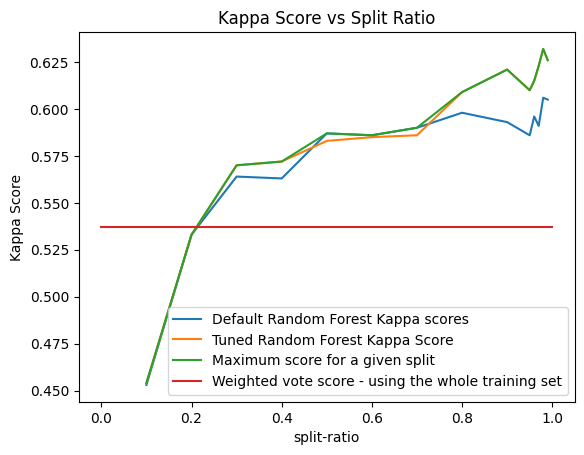

In [ ]:
# Creating plot for tuning results
splits = [x/10 for x in range(1,10,1)]
splits.extend([0.95, 0.96, 0.97, 0.98, 0.99])
plt.plot(splits, baseline_scores , label='Default Random Forest Kappa scores')
plt.plot(splits , tuned_scores ,label='Tuned Random Forest Kappa Score')
plt.plot(splits, maximum_scores, label='Maximum score for a given split')
plt.plot([0,1],[0.537, 0.537], label='Weighted vote score - using the whole training set')
plt.legend()
plt.xlabel('split-ratio')
plt.ylabel('Kappa Score')
plt.title('Kappa Score vs Split Ratio')


In [ ]:
splits = [x/10 for x in range(1,10,1)]
splits.extend([0.95, 0.96, 0.97, 0.98, 0.99])
splits

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99]

In [ ]:

df_train, df_test = burrows_read_input_json("dev-labels")
train_corpus, test_corpus = burrows_corpus_make(df_train, df_test)
burrows_preds = burrows_predictions_make(train_corpus, test_corpus, df_test, 10)

df_train, df_test = read_input_json("dev-labels")
read_df_train, read_df_test = pca_dataframes_make(df_train, df_test) 
pca_preds = pipelined_pca(read_df_train, read_df_test, True)

df_train, df_test = read_input_json("dev-labels")
tfidf_preds = tfidf_predict(df_train, df_test )


preds = [burrows_preds, pca_preds, tfidf_preds ]
weights = [0.273, 0.432 , 0.512]
final_preds = weighted_voting(preds,weights)
cohen_kappa_score(final_preds, df_test['label'])


0.5369884994487701

## PHASE 2 sumbissions with different split ratios

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.model_selection import train_test_split

df_train, df_test = read_input_json("test")
X_train , Y_train = df_train.iloc[:,:-1] , df_train.iloc[:,-1]

In [28]:
X_mini_train , X_valid, Y_mini_train , Y_valid = train_test_split( X_train, Y_train , train_size = 0.50 , random_state=100, shuffle=True,  stratify= Y_train )
df_mini_train = pd.concat([X_mini_train, Y_mini_train ] , axis=1)
df_valid = pd.concat([X_valid, Y_valid ] , axis=1)

train_corpus, test_corpus = burrows_corpus_make(df_mini_train, df_valid)
result = calculate_burrows_delta(train_corpus, test_corpus ,10)
machine_prob_scores = result.iloc[0,:] / (result.iloc[0,:] + result.iloc[1,:])
machine_probs = machine_prob_scores.copy()
b = [ind.split(" - ")[1] for ind in machine_probs.index]
burrows_machine_proba = list(pd.Series(data = list(machine_probs), index = b).reindex(df_valid['id']))
burrows_machine_proba_valid = [0.5 if math.isnan(x) else x for x in burrows_machine_proba]
train_corpus, test_corpus = burrows_corpus_make(df_mini_train, df_test)
result = calculate_burrows_delta(train_corpus, test_corpus ,10)
machine_prob_scores = result.iloc[0,:] / (result.iloc[0,:] + result.iloc[1,:])
machine_probs = machine_prob_scores.copy()
b = [ind.split(" - ")[1] for ind in machine_probs.index]
burrows_machine_proba = list(pd.Series(data = list(machine_probs), index = b).reindex(df_test['id']))
burrows_machine_proba_test = [0.5 if math.isnan(x) else x for x in burrows_machine_proba]

read_df_train, read_df_test = pca_dataframes_make(df_mini_train, df_valid) 
pca_preds = pipelined_pca_proba(read_df_train, read_df_test, True)
pca_machine_proba_valid = [x[1] for x in pca_preds]
read_df_train, read_df_test = pca_dataframes_make(df_mini_train, df_test) 
pca_preds = pipelined_pca_proba(read_df_train, read_df_test, True)
pca_machine_proba_test = [x[1] for x in pca_preds]

tfidf_proba = tfidf_predict_proba(df_mini_train, df_valid )   
tfidf_proba_machine_valid =  [x[1] for x in tfidf_proba]
tfidf_proba = tfidf_predict_proba(df_mini_train, df_test )   
tfidf_proba_machine_test =  [x[1] for x in tfidf_proba]

valid_preds_df = pd.DataFrame({'burrows_machine_pred':burrows_machine_proba_valid, 'pca_machine_pred':pca_machine_proba_valid, 'tfidf_machine_pred':tfidf_proba_machine_valid, 'label':Y_valid})
test_preds_df = pd.DataFrame( {'burrows_machine_pred':burrows_machine_proba_test, 'pca_machine_pred':pca_machine_proba_test, 'tfidf_machine_pred':tfidf_proba_machine_test} )

kappa_scorer = make_scorer(cohen_kappa_score)
rf = RandomForestClassifier(random_state=42)
rf.fit(valid_preds_df.iloc[:, :-1], valid_preds_df.iloc[:, -1])
test_preds = rf.predict(test_preds_df)




C:\Users\joelj\AppData\Roaming\Python\Python39\site-packages\faststylometry\burrows_delta.py:159: RuntimeWarning: invalid value encountered in divide
  corpus.token_proportions = corpus.token_counts_by_author / corpus.total_token_counts_by_author
C:\Users\joelj\AppData\Roaming\Python\Python39\site-packages\faststylometry\burrows_delta.py:159: RuntimeWarning: invalid value encountered in divide
  corpus.token_proportions = corpus.token_counts_by_author / corpus.total_token_counts_by_author


In [ ]:
# test_preds
# make_json(test_preds, df_test)



In [26]:


random_grid = {
    'n_estimators': [100, 200, 300, 500,700],
    'max_features': [1,2,3],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 10],
    'bootstrap': [True,False]
}

random_search = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1,scoring=kappa_scorer)
# Fit the model
random_search.fit(valid_preds_df.iloc[:, :-1], valid_preds_df.iloc[:, -1])
tuned_model = random_search.best_estimator_
tuned_preds = tuned_model.predict(test_preds_df)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [29]:

make_json(test_preds, df_test)

JSON file with labels created successfully!
